# Emergence of structure–performance insights

- We replicate the analysis on whether fine-tuning RXNGraphormer yields deeper chemical insights than the pre-trained model alone.
## 1.SPR insights of the sub-cat test set

In [3]:
import json
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.manifold import TSNE

from rxngraphormer.data import get_idx_split
from rxngraphormer.rxn_emb import RXNEMB

warnings.filterwarnings("ignore")

Processing...
 12%|█▏        | 21/171 [00:00<00:00, 204.71it/s]

[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 171/171 [00:00<00:00, 202.88it/s]
Done!
Processing...
 35%|███▌      | 60/171 [00:00<00:00, 598.47it/s]

[INFO] 171 data index 0 is saving...
[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 171/171 [00:00<00:00, 522.44it/s]
Done!
  0%|          | 0/2 [00:00<?, ?it/s]

[INFO] 171 data index 0 is saving...
[INFO] Generating reaction embedding...


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


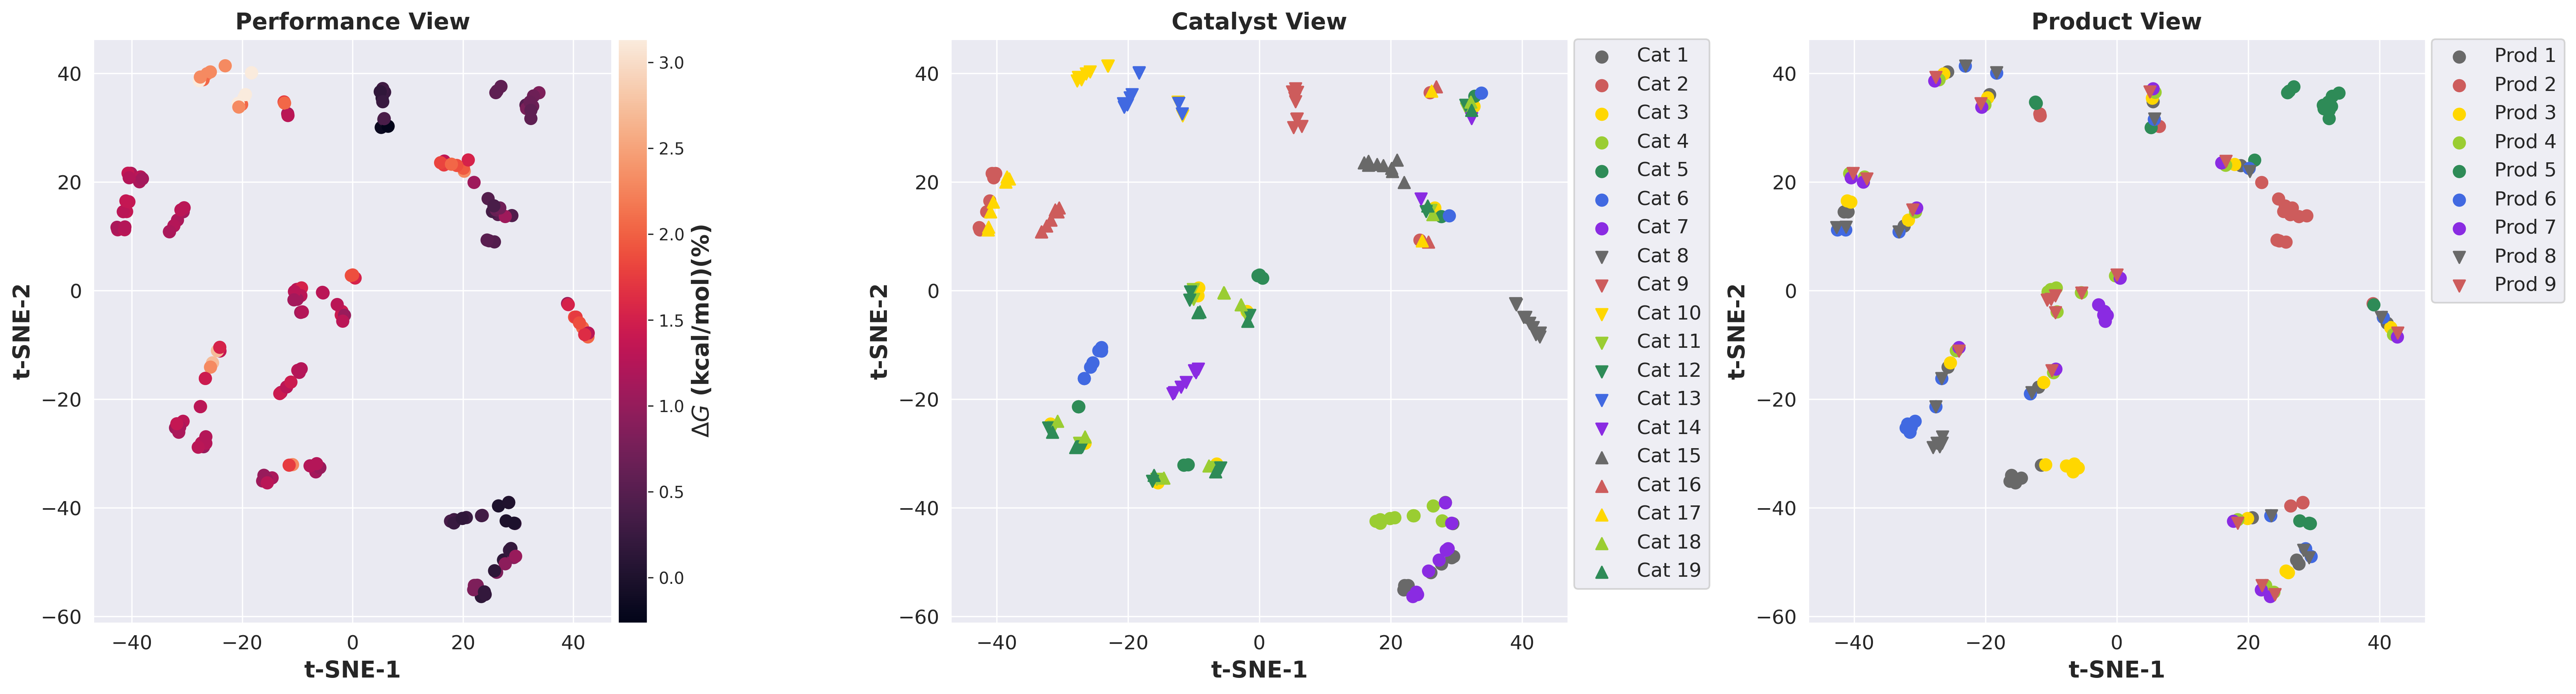

In [4]:
os.makedirs('./5_SPR_PNG', exist_ok=True)
TICK_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
PERPLEXITY = 5
COLORS = ['dimgray', 'indianred', 'gold', 'yellowgreen', 'seagreen',
          'royalblue', 'blueviolet']
MARKERS = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '.', ',', '1', '2']

sub_pdt_path = '../dataset/OOS/thiol_addition_sub_cat_test_pdt.csv'
sub_rct_path = '../dataset/OOS/thiol_addition_sub_cat_test_rct.csv'
sub_ft_model_path = "../model_path/thiol_addition/sub_cat_OOS"

sub_pdt_df = pd.read_csv(sub_pdt_path, header=None)
sub_rct_df = pd.read_csv(sub_rct_path, header=None)

sub_rxn = sub_rct_df.iloc[:, 0] + ">>" + sub_pdt_df.iloc[:, 0]
sub_label = sub_pdt_df.iloc[:, 1]

rxnemb = RXNEMB(pretrained_model_path=sub_ft_model_path, model_type="regressor")
sub_rxn_emb = rxnemb.gen_rxn_emb(sub_rxn)

# Generate 2D embeddings
tsne = TSNE(
    n_components=2,
    perplexity=PERPLEXITY,
    learning_rate=200,
    init="pca",
    random_state=42
)
ds_rxn_emb_2d = tsne.fit_transform(sub_rxn_emb)

# Prepare catalyst mapping
phos_smi_lst = [smi for rct in sub_rct_df.iloc[:, 0] for smi in rct.split('.')
                if 'P' in smi or 'p' in smi]
phos_smi_set = list(set(phos_smi_lst))
phos_smi_id_map = {smi: i for i, smi in enumerate(phos_smi_set)}
phos_id_smi_map = {i: smi for i, smi in enumerate(phos_smi_set)}

catalyst_ids = np.full(len(sub_rct_df), -1, dtype=int)
for i, rct in enumerate(sub_rct_df.iloc[:, 0]):
    for smi in rct.split('.'):
        if 'P' in smi or 'p' in smi:
            catalyst_ids[i] = phos_smi_id_map[smi]
            break

# Prepare product mapping
pdt_dataset = sub_pdt_df.iloc[:, 0].tolist()
pdt_smi_set = list(set(pdt_dataset))
pdt_smi_id_map = {smi: i for i, smi in enumerate(pdt_smi_set)}
pdt_id_arr = np.array([pdt_smi_id_map[smi] for smi in pdt_dataset])

# Create figure
plt.figure(figsize=(22, 6), dpi=300)

# Performance view with colorbar
plt.subplot(1, 3, 1)
scatter = plt.scatter(ds_rxn_emb_2d[:, 0], ds_rxn_emb_2d[:, 1], c=sub_label, s=50)
cbar = plt.colorbar(scatter, pad=0.01)
cbar.set_label(r"$\Delta G$ (kcal/mol)(%)", fontsize=LABEL_FONT_SIZE, fontweight='bold')
plt.xlabel('t-SNE-1', fontsize=LABEL_FONT_SIZE, fontweight='bold')
plt.ylabel('t-SNE-2', fontsize=LABEL_FONT_SIZE, fontweight='bold')
plt.xticks(fontsize=TICK_FONT_SIZE)
plt.yticks(fontsize=TICK_FONT_SIZE)
plt.title('Performance View', fontsize=LABEL_FONT_SIZE, fontweight='bold')

# Catalyst view
plt.subplot(1, 3, 2)
for cat_id in range(len(phos_smi_set)):
    mask = (catalyst_ids == cat_id)
    x, y = ds_rxn_emb_2d[mask, 0], ds_rxn_emb_2d[mask, 1]
    if len(x) > 0:
        color_idx = cat_id % 7
        marker = MARKERS[cat_id // 7]
        plt.scatter(x, y, c=COLORS[color_idx], marker=marker, s=50,
                    label=f'Cat {cat_id + 1}')
plt.xlabel('t-SNE-1', fontsize=LABEL_FONT_SIZE, fontweight='bold')
plt.ylabel('t-SNE-2', fontsize=LABEL_FONT_SIZE, fontweight='bold')
plt.xticks(fontsize=TICK_FONT_SIZE)
plt.yticks(fontsize=TICK_FONT_SIZE)
plt.title('Catalyst View', fontsize=LABEL_FONT_SIZE, fontweight='bold')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=TICK_FONT_SIZE)

# Product view
plt.subplot(1, 3, 3)
for prod_id in range(len(pdt_smi_set)):
    mask = (pdt_id_arr == prod_id)
    x, y = ds_rxn_emb_2d[mask, 0], ds_rxn_emb_2d[mask, 1]
    if len(x) > 0:
        color_idx = prod_id % 7
        marker = MARKERS[prod_id // 7]
        plt.scatter(x, y, c=COLORS[color_idx], marker=marker, s=50,
                    label=f'Prod {prod_id + 1}')
plt.xlabel('t-SNE-1', fontsize=LABEL_FONT_SIZE, fontweight='bold')
plt.ylabel('t-SNE-2', fontsize=LABEL_FONT_SIZE, fontweight='bold')
plt.xticks(fontsize=TICK_FONT_SIZE)
plt.yticks(fontsize=TICK_FONT_SIZE)
plt.title('Product View', fontsize=LABEL_FONT_SIZE, fontweight='bold')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=TICK_FONT_SIZE)

plt.tight_layout()
plt.savefig('./5_SPR_PNG/ta_reaction_embeddings.png', bbox_inches='tight', dpi=300)
plt.show()

- **High-selectivity Cat**

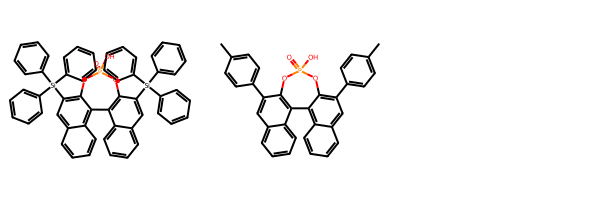

In [5]:
Draw.MolsToGridImage([Chem.MolFromSmiles(phos_id_smi_map[7 - 1]), Chem.MolFromSmiles(phos_id_smi_map[11 - 1])])

**Low-selectivity Cat**

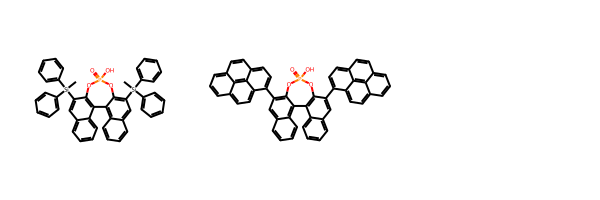

In [6]:
Draw.MolsToGridImage([Chem.MolFromSmiles(phos_id_smi_map[1 - 1]), Chem.MolFromSmiles(phos_id_smi_map[6 - 1])])

## 2. Four benchmark datasets

In [7]:
# Buchwald
BH_rct_path = '../dataset/bechmark/BH_rct_tot.csv'
BH_mech_path = '../dataset/bechmark/BH_mech_tot.csv'
BH_pdt_path = '../dataset/bechmark/BH_pdt_tot.csv'

# suzuki
SM_rct_path = '../dataset/bechmark/SM_rct_tot.csv'
SM_mech_path = '../dataset/bechmark/SM_mech_tot.csv'
SM_pdt_path = '../dataset/bechmark/SM_pdt_tot.csv'

# thiol
thiol_rct_path = '../dataset/bechmark/thiol_add_rct_tot.csv'
thiol_mech_path = '../dataset/bechmark/thiol_add_mech_tot.csv'
thiol_pdt_path = '../dataset/bechmark/thiol_add_pdt_tot.csv'

#C-H
C_H_func_rct_path = '../dataset/bechmark/C_H_func_rct_tot.csv'
C_H_func_mech_path = '../dataset/bechmark/C_H_func_mech_tot.csv'
C_H_func_pdt_path = "../dataset/bechmark/C_H_func_pdt_tot.csv"

pretrain_model_path = "../model_path/pretrained_classification_model"
BH_model_path = "../model_path/buchwald_hartwig/seed0"
SM_model_path = "../model_path/suzuki_miyaura/seed0"
thiol_model_path = "../model_path/thiol_addition/seed0"
C_H_model_path = "../model_path/C_H_func/seed0"

In [8]:
import os

os.makedirs('./5_SPR_PNG', exist_ok=True)


def generate_test_rxn_embeddings(rct_path, pdt_path, pre_model_path, ft_model_path, model_type):
    rct_df = pd.read_csv(rct_path, header=None)
    pdt_df = pd.read_csv(pdt_path, header=None)

    with open(f"{ft_model_path}/parameters.json") as fr:
        config = json.load(fr)

    total = len(rct_df)
    train_size = int(config["data"]["train_ratio"] * total)
    valid_size = int(config["data"]["valid_ratio"] * total)

    test_indices = get_idx_split(total, train_size, valid_size, config["data"]["seed"])["test"]
    test_rct = rct_df.iloc[test_indices]
    test_pdt = pdt_df.iloc[test_indices]
    label = test_pdt.iloc[:, 1]
    combined = test_rct.iloc[:, 0] + ">>" + test_pdt.iloc[:, 0]

    pre_rxnemb = RXNEMB(pretrained_model_path=pre_model_path)
    ft_rxnemb = RXNEMB(pretrained_model_path=ft_model_path, model_type=model_type)
    pre_rxn_emb = pre_rxnemb.gen_rxn_emb(combined)
    ft_rxn_emb = ft_rxnemb.gen_rxn_emb(combined)

    return label, pre_rxn_emb, ft_rxn_emb


def plot_tsne_comparison(label, pre_rxn_emb, ft_rxn_emb, bar_title, title_pre, title_ft, start, end, step,
                         is_yield=True):
    perplexity = 5
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate="auto", init="pca", random_state=42)

    pre_emb_2d = tsne.fit_transform(pre_rxn_emb)
    ft_emb_2d = tsne.fit_transform(ft_rxn_emb)

    colors = label * 100 if is_yield else label

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

    # Pre-trained plot
    sc1 = ax1.scatter(pre_emb_2d[:, 0], pre_emb_2d[:, 1], c=colors, cmap='viridis', s=30, alpha=0.8)
    ax1.set_xlabel('t-SNE-1', fontweight='bold', fontsize=12)
    ax1.set_ylabel('t-SNE-2', fontweight='bold', fontsize=12)
    ax1.set_title(title_pre, pad=20, fontweight='bold', fontsize=14)
    cbar1 = plt.colorbar(sc1, ax=ax1)
    cbar1.set_label(bar_title, rotation=270, labelpad=20)
    cbar1.set_ticks(np.linspace(start, end, step))
    cbar1.set_ticklabels([f'{tick:.1f}' for tick in cbar1.get_ticks()])

    # Fine-tuned plot
    sc2 = ax2.scatter(ft_emb_2d[:, 0], ft_emb_2d[:, 1], c=colors, cmap='viridis', s=30, alpha=0.8)
    ax2.set_xlabel('t-SNE-1', fontweight='bold', fontsize=12)
    ax2.set_ylabel('t-SNE-2', fontweight='bold', fontsize=12)
    ax2.set_title(title_ft, pad=20, fontweight='bold', fontsize=14)
    cbar2 = plt.colorbar(sc2, ax=ax2)
    cbar2.set_label(bar_title, rotation=270, labelpad=20)
    cbar2.set_ticks(np.linspace(start, end, step))
    cbar2.set_ticklabels([f'{tick:.1f}' for tick in cbar2.get_ticks()])

    plt.tight_layout()
    plt.savefig(f'./5_SPR_PNG/{title_pre.replace(" ", "_")}_vs_{title_ft.replace(" ", "_")}_emb.png',
                bbox_inches='tight', dpi=300)
    plt.show()


def emb_tsne_comparison(
        rct_path,
        pdt_path,
        pre_model_path,
        ft_model_path,
        model_type,
        bar_title="Yield(%)",
        title_pre="pretrained",
        title_ft="fine-tuned",
        start=0.0,
        end=100,
        step=5,
        is_yield=True
):
    label, pre_rxn_emb, ft_rxn_emb = generate_test_rxn_embeddings(
        rct_path, pdt_path, pre_model_path, ft_model_path, model_type
    )
    plot_tsne_comparison(
        label, pre_rxn_emb, ft_rxn_emb, bar_title, title_pre, title_ft, start, end, step, is_yield
    )

Processing...
  1%|          | 18/1729 [00:00<00:09, 176.05it/s]

[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1729/1729 [00:09<00:00, 183.29it/s]
Done!
Processing...
  0%|          | 0/1729 [00:00<?, ?it/s]

[INFO] 1729 data index 0 is saving...
[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1729/1729 [00:03<00:00, 557.09it/s]
Done!
  0%|          | 0/14 [00:00<?, ?it/s]

[INFO] 1729 data index 0 is saving...
[INFO] Generating reaction embedding...


100%|██████████| 14/14 [00:02<00:00,  6.32it/s]
Processing...
  1%|          | 19/1729 [00:00<00:09, 183.65it/s]

[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1729/1729 [00:10<00:00, 171.99it/s]
Done!
Processing...
  0%|          | 0/1729 [00:00<?, ?it/s]

[INFO] 1729 data index 0 is saving...
[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1729/1729 [00:03<00:00, 478.12it/s]
Done!
  0%|          | 0/14 [00:00<?, ?it/s]

[INFO] 1729 data index 0 is saving...
[INFO] Generating reaction embedding...


100%|██████████| 14/14 [00:02<00:00,  5.08it/s]


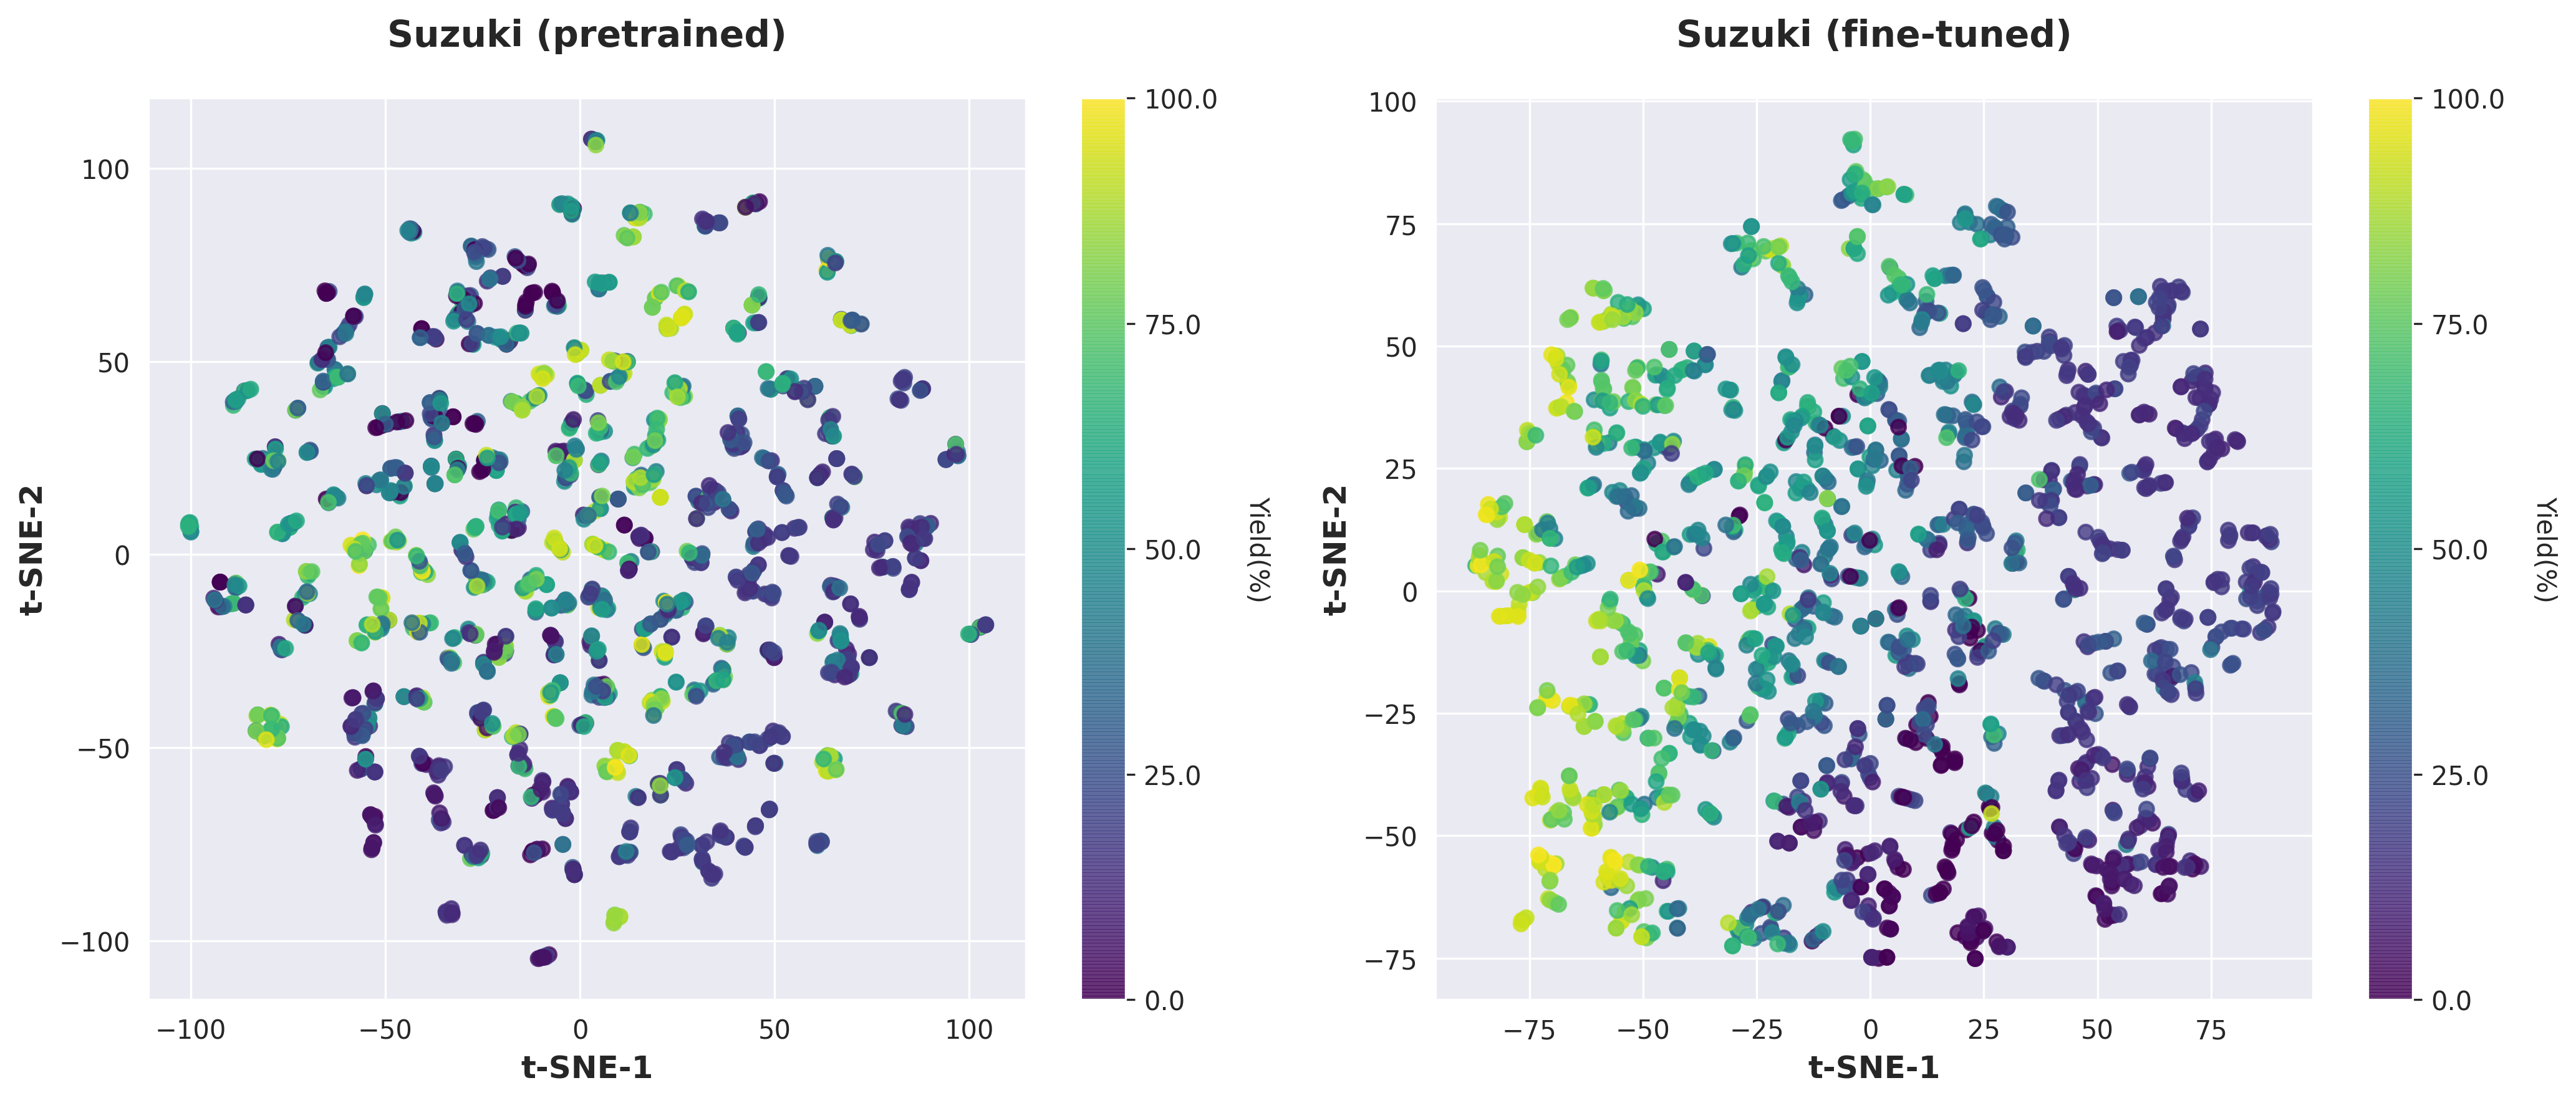

In [9]:
# "regressor","classifier"
emb_tsne_comparison(
    rct_path=SM_rct_path,
    pdt_path=SM_pdt_path,
    pre_model_path=pretrain_model_path,
    ft_model_path=SM_model_path,
    # "regressor","classifier"
    model_type="regressor",
    bar_title="Yield(%)",
    title_pre="Suzuki (pretrained)",
    title_ft="Suzuki (fine-tuned)"
)

Processing...
  2%|▏         | 21/1187 [00:00<00:05, 202.67it/s]

[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1187/1187 [00:06<00:00, 181.94it/s]
Done!
Processing...
  7%|▋         | 85/1187 [00:00<00:01, 848.26it/s]

[INFO] 1187 data index 0 is saving...
[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1187/1187 [00:01<00:00, 817.05it/s]
Done!
 10%|█         | 1/10 [00:00<00:01,  6.06it/s]

[INFO] 1187 data index 0 is saving...
[INFO] Generating reaction embedding...


100%|██████████| 10/10 [00:01<00:00,  8.08it/s]
Processing...
  2%|▏         | 21/1187 [00:00<00:05, 200.00it/s]

[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1187/1187 [00:06<00:00, 180.18it/s]
Done!
Processing...
  7%|▋         | 86/1187 [00:00<00:01, 857.65it/s]

[INFO] 1187 data index 0 is saving...
[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1187/1187 [00:01<00:00, 847.73it/s]
Done!
 10%|█         | 1/10 [00:00<00:01,  7.85it/s]

[INFO] 1187 data index 0 is saving...
[INFO] Generating reaction embedding...


100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


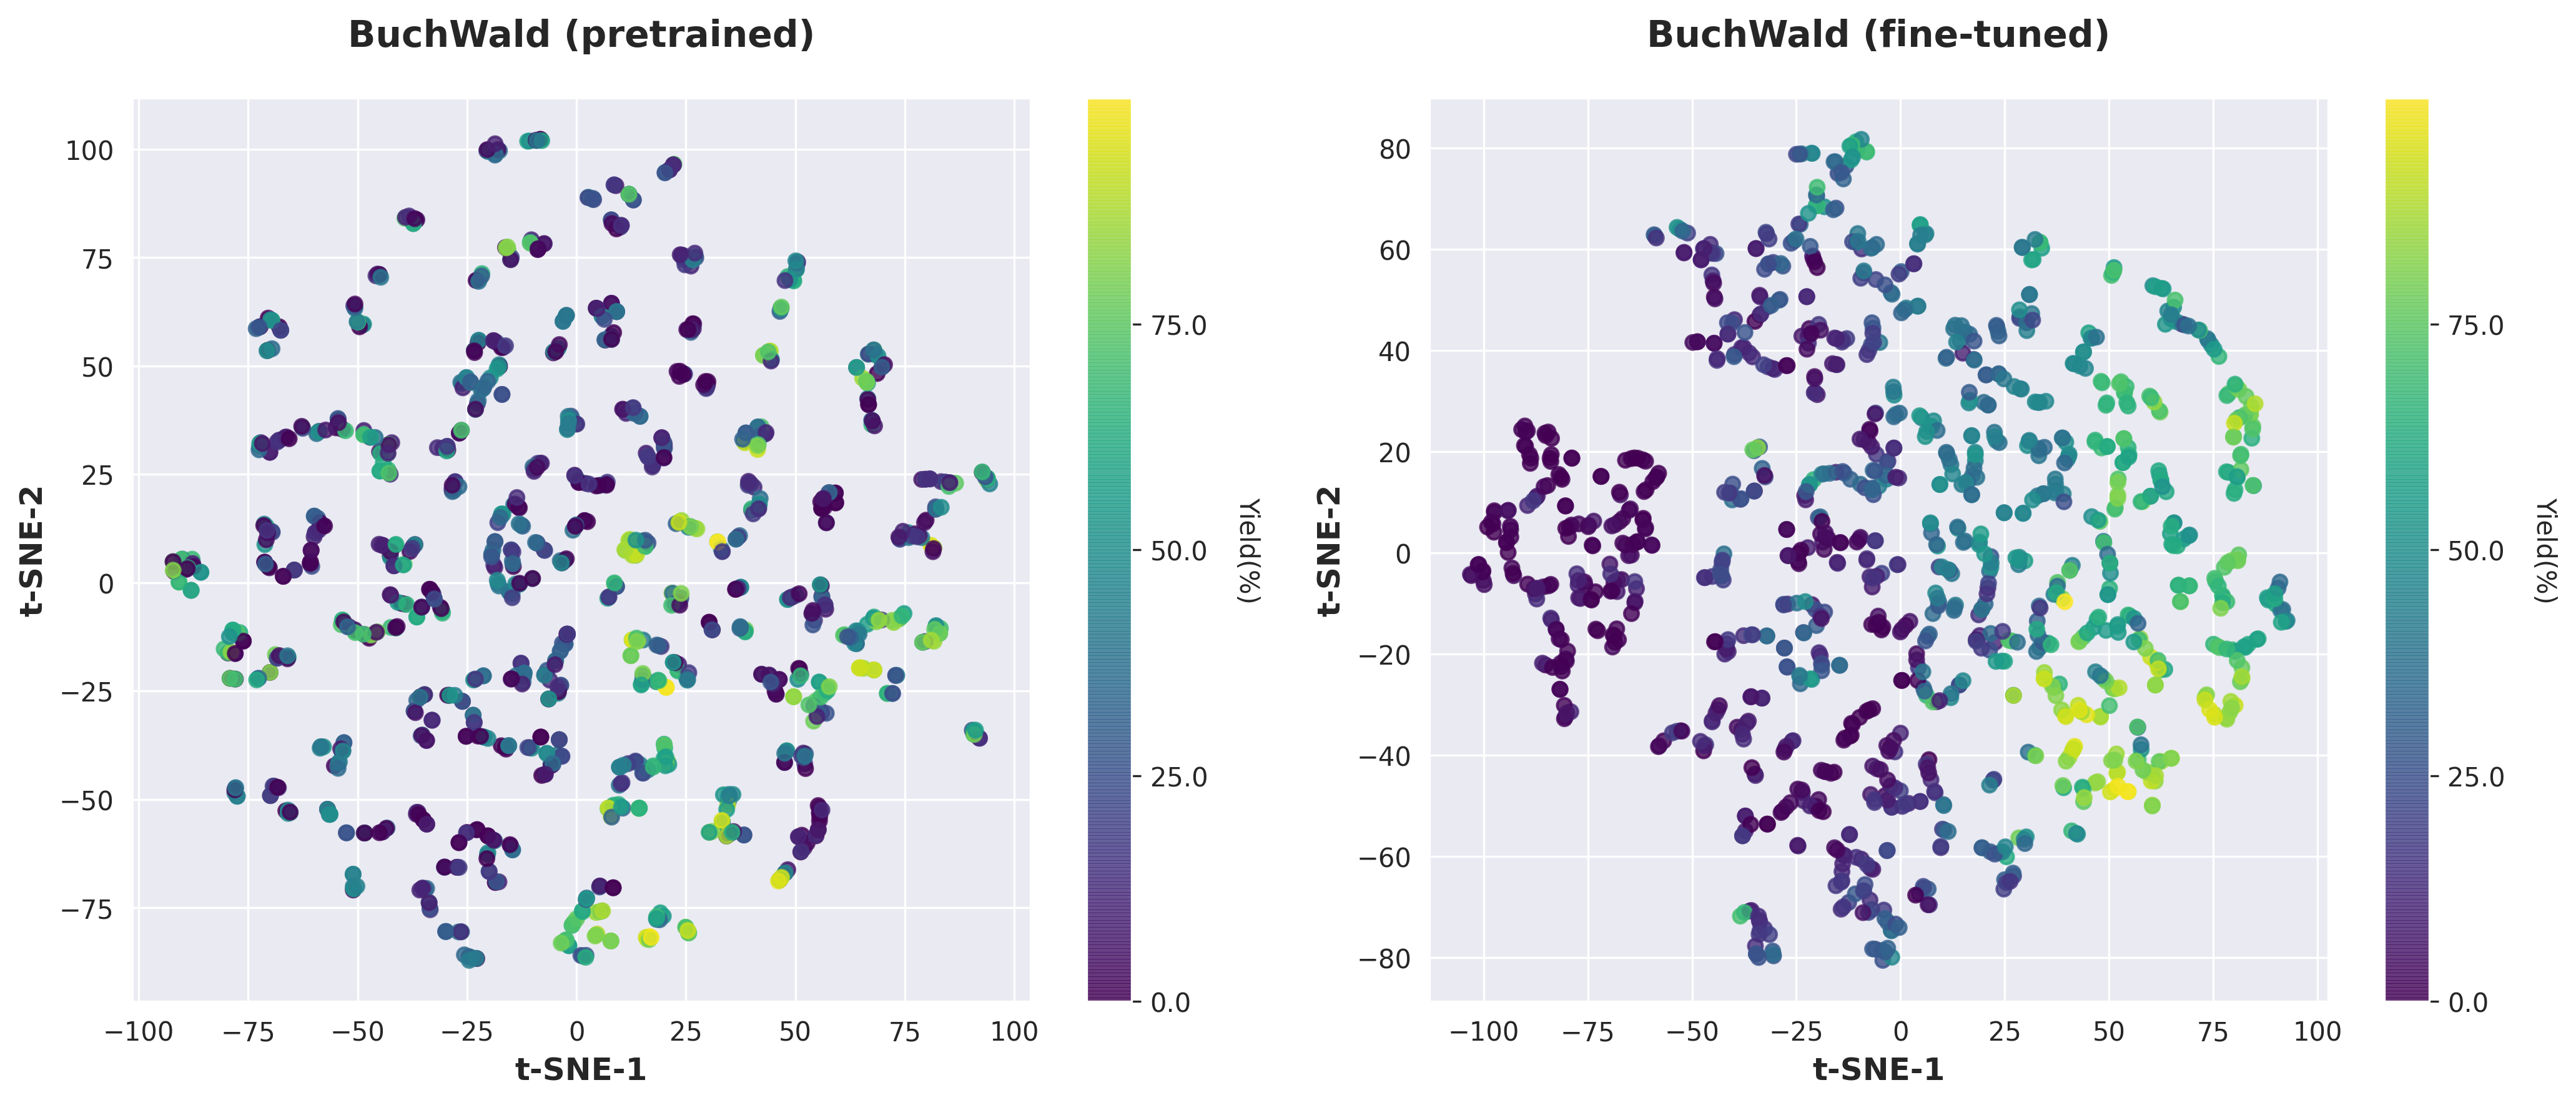

In [10]:
emb_tsne_comparison(
    rct_path=BH_rct_path,
    pdt_path=BH_pdt_path,
    pre_model_path=pretrain_model_path,
    ft_model_path=BH_model_path,
    # "regressor","classifier"
    model_type="regressor",
    bar_title="Yield(%)",
    title_pre="BuchWald (pretrained)",
    title_ft="BuchWald (fine-tuned)"
)

Processing...
  4%|▍         | 21/475 [00:00<00:02, 209.74it/s]

[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 475/475 [00:02<00:00, 197.39it/s]
Done!
Processing...
 13%|█▎        | 63/475 [00:00<00:00, 621.85it/s]

[INFO] 475 data index 0 is saving...
[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 475/475 [00:00<00:00, 604.54it/s]
Done!
 25%|██▌       | 1/4 [00:00<00:00,  8.48it/s]

[INFO] 475 data index 0 is saving...
[INFO] Generating reaction embedding...


100%|██████████| 4/4 [00:00<00:00,  9.40it/s]
Processing...
  5%|▍         | 22/475 [00:00<00:02, 213.83it/s]

[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 475/475 [00:02<00:00, 195.18it/s]
Done!
Processing...
 13%|█▎        | 63/475 [00:00<00:00, 620.12it/s]

[INFO] 475 data index 0 is saving...
[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 475/475 [00:00<00:00, 553.20it/s]
Done!
 25%|██▌       | 1/4 [00:00<00:00,  7.04it/s]

[INFO] 475 data index 0 is saving...
[INFO] Generating reaction embedding...


100%|██████████| 4/4 [00:00<00:00,  7.49it/s]


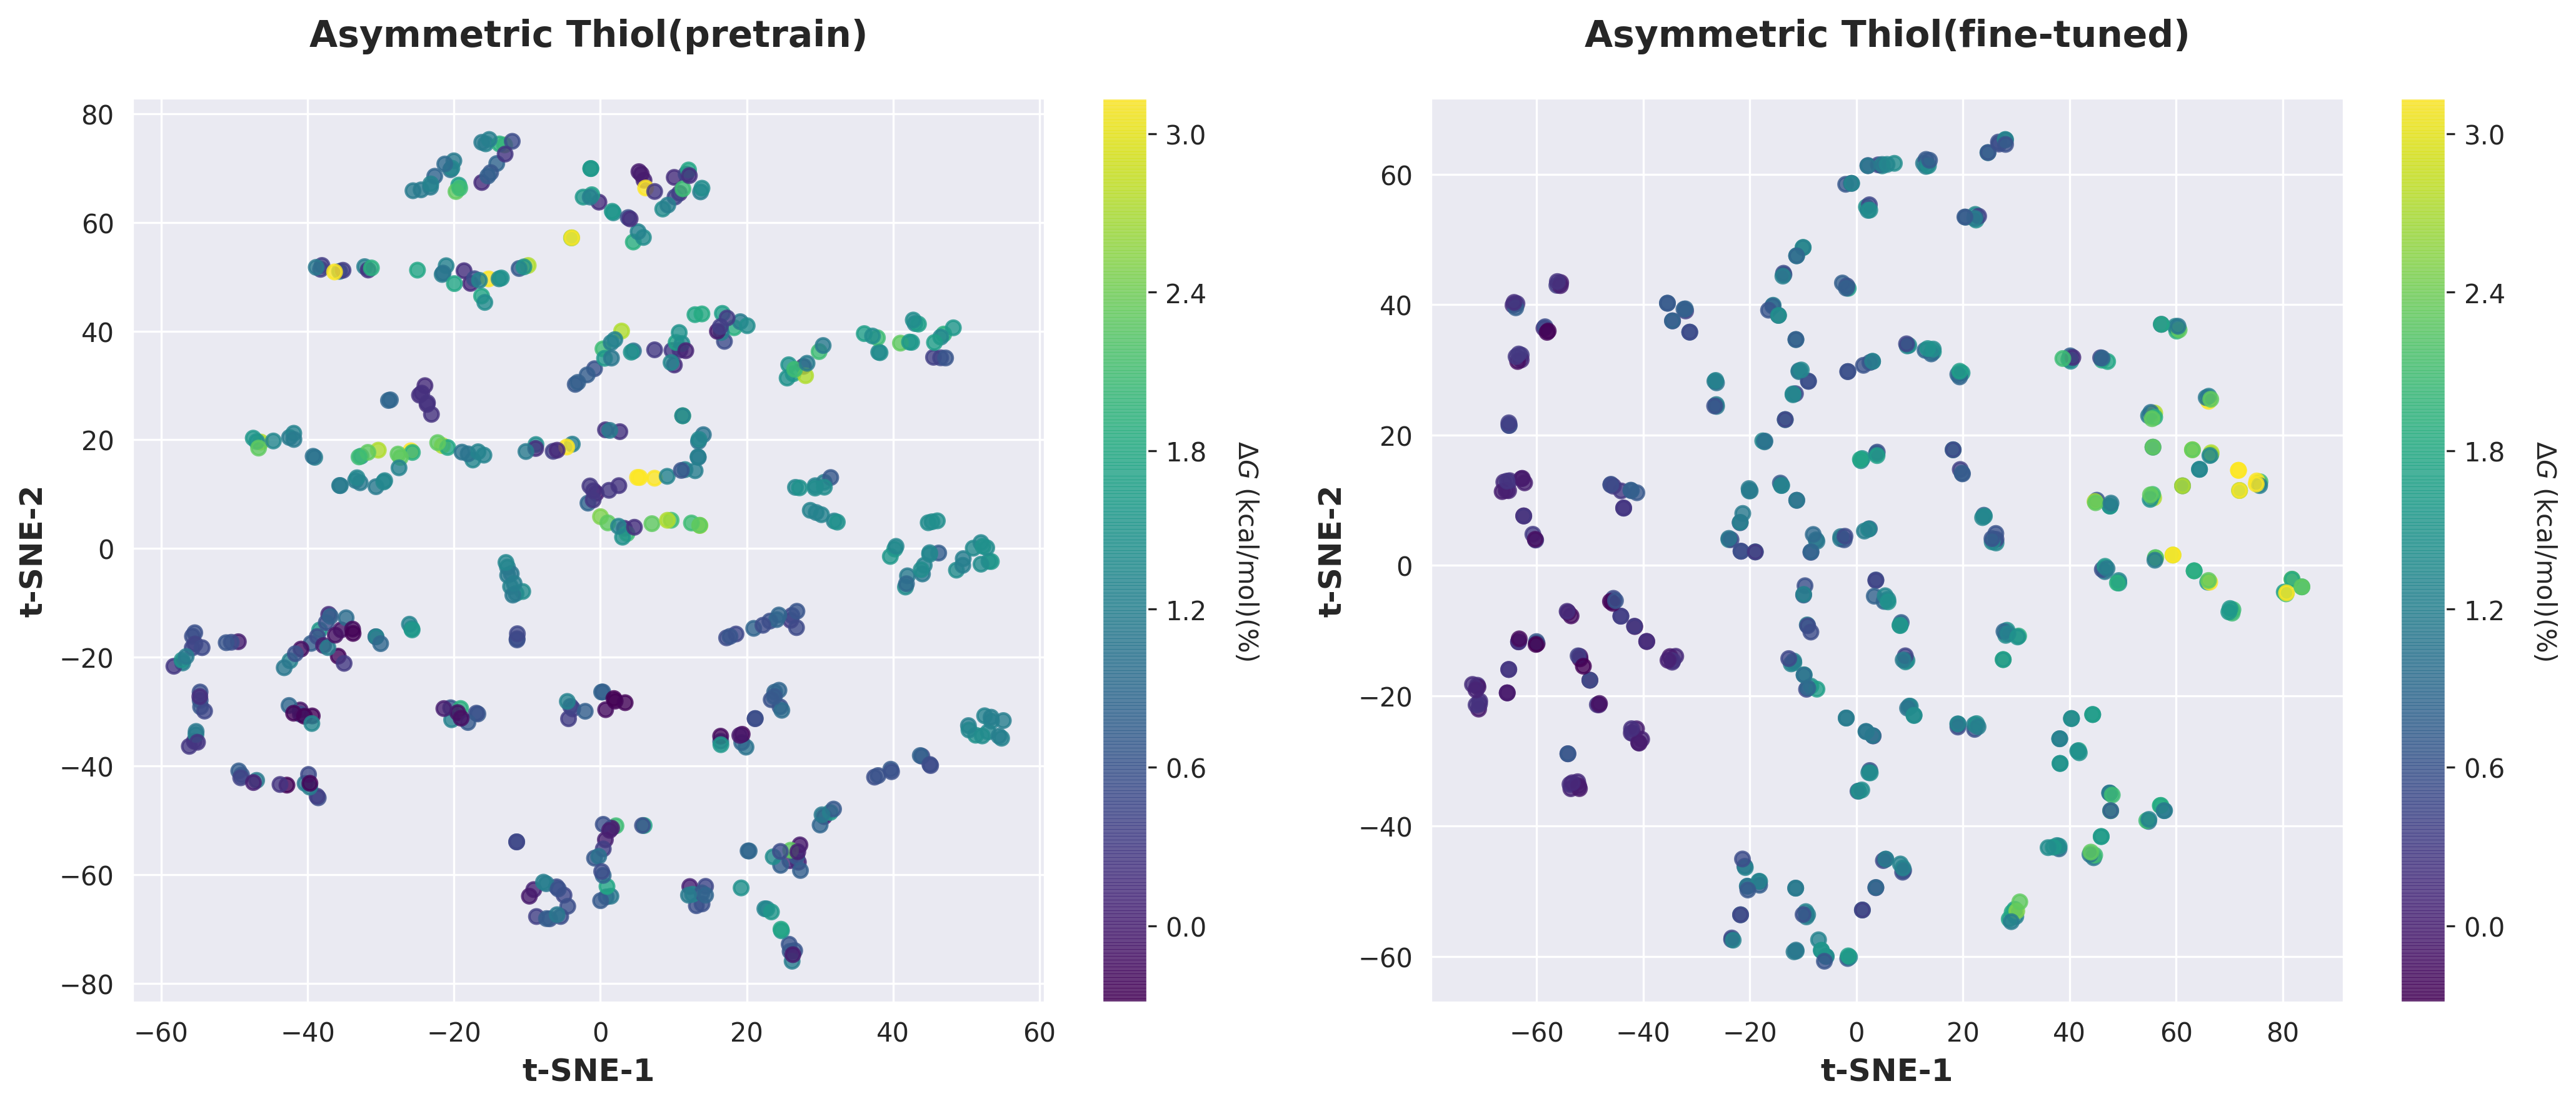

In [11]:
emb_tsne_comparison(
    rct_path=thiol_rct_path,
    pdt_path=thiol_pdt_path,
    pre_model_path=pretrain_model_path,
    ft_model_path=thiol_model_path,
    # "regressor","classifier"
    model_type="regressor",
    bar_title=r"$\Delta G$ (kcal/mol)(%)",
    title_pre="Asymmetric Thiol(pretrain)",
    title_ft="Asymmetric Thiol(fine-tuned)",
    start=0.0,
    end=3.0,
    step=6,
    is_yield=False
)

Processing...
  8%|▊         | 97/1223 [00:00<00:01, 965.39it/s]

[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1223/1223 [00:01<00:00, 934.74it/s]
Done!
Processing...
  9%|▊         | 107/1223 [00:00<00:01, 1068.04it/s]

[INFO] 1223 data index 0 is saving...
[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1223/1223 [00:01<00:00, 1070.31it/s]
Done!
 20%|██        | 2/10 [00:00<00:00, 11.96it/s]

[INFO] 1223 data index 0 is saving...
[INFO] Generating reaction embedding...


100%|██████████| 10/10 [00:00<00:00, 12.31it/s]
Processing...
  8%|▊         | 95/1223 [00:00<00:01, 946.13it/s]

[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1223/1223 [00:01<00:00, 951.97it/s]
Done!
Processing...
  9%|▉         | 110/1223 [00:00<00:01, 1096.32it/s]

[INFO] 1223 data index 0 is saving...
[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1223/1223 [00:01<00:00, 928.56it/s]
Done!
 20%|██        | 2/10 [00:00<00:00, 12.17it/s]

[INFO] 1223 data index 0 is saving...
[INFO] Generating reaction embedding...


100%|██████████| 10/10 [00:00<00:00, 12.37it/s]


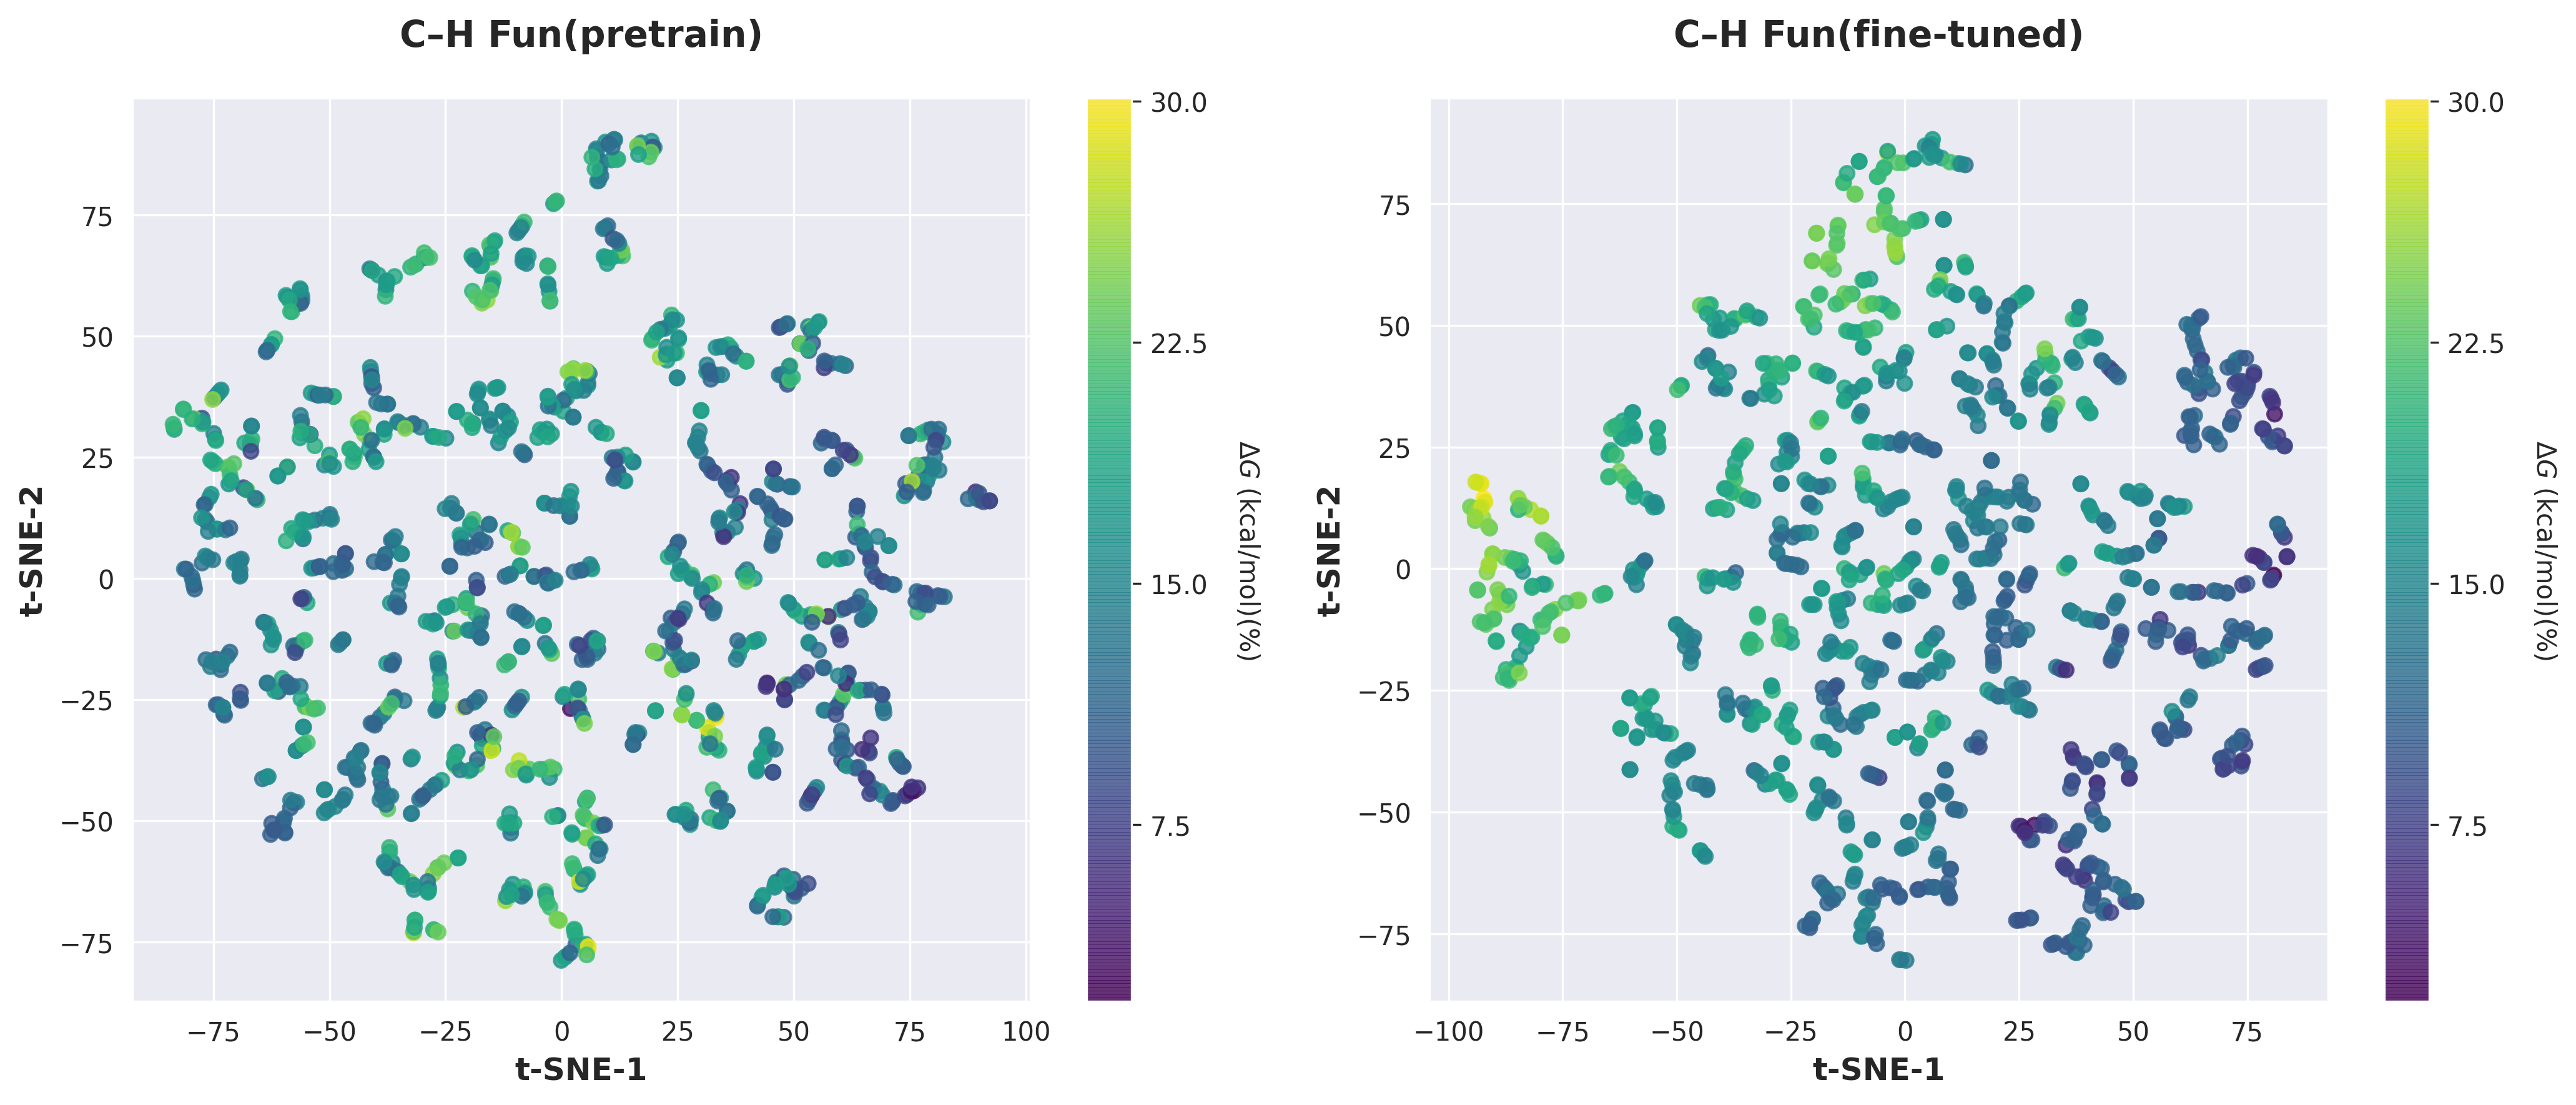

In [12]:
emb_tsne_comparison(
    rct_path=C_H_func_rct_path,
    pdt_path=C_H_func_pdt_path,
    pre_model_path=pretrain_model_path,
    ft_model_path=C_H_model_path,
    # "regressor","classifier"
    model_type="regressor",
    bar_title=r"$\Delta G$ (kcal/mol)(%)",
    title_pre="C–H Fun(pretrain)",
    title_ft="C–H Fun(fine-tuned)",
    start=0,
    end=30,
    step=5,
    is_yield=False
)